[INFO] Successfully loaded 'day(new).csv'
[INFO] Weekend column created.
[INFO] Normalizing temp, hum, windspeed...
[INFO] Normalization completed.

--------------------------------------------------
Running Predictions using Trained Models
--------------------------------------------------

[INFO] Loading model: Decision Tree
[INFO] Predictions generated using Decision Tree

[INFO] Loading model: Linear Regression
[INFO] Predictions generated using Linear Regression

[INFO] Loading model: Lasso
[INFO] Predictions generated using Lasso

[INFO] Loading model: Ridge
[INFO] Predictions generated using Ridge

[INFO] Loading model: Elastic Net
[INFO] Predictions generated using Elastic Net

--------------------------------------------------
BEST MODEL (Fixed): Decision Tree
--------------------------------------------------
--------------------------------------------------
Mean Absolute Error (MAE): 4453.57 bikes (Using Decision Tree)
--------------------------------------------------


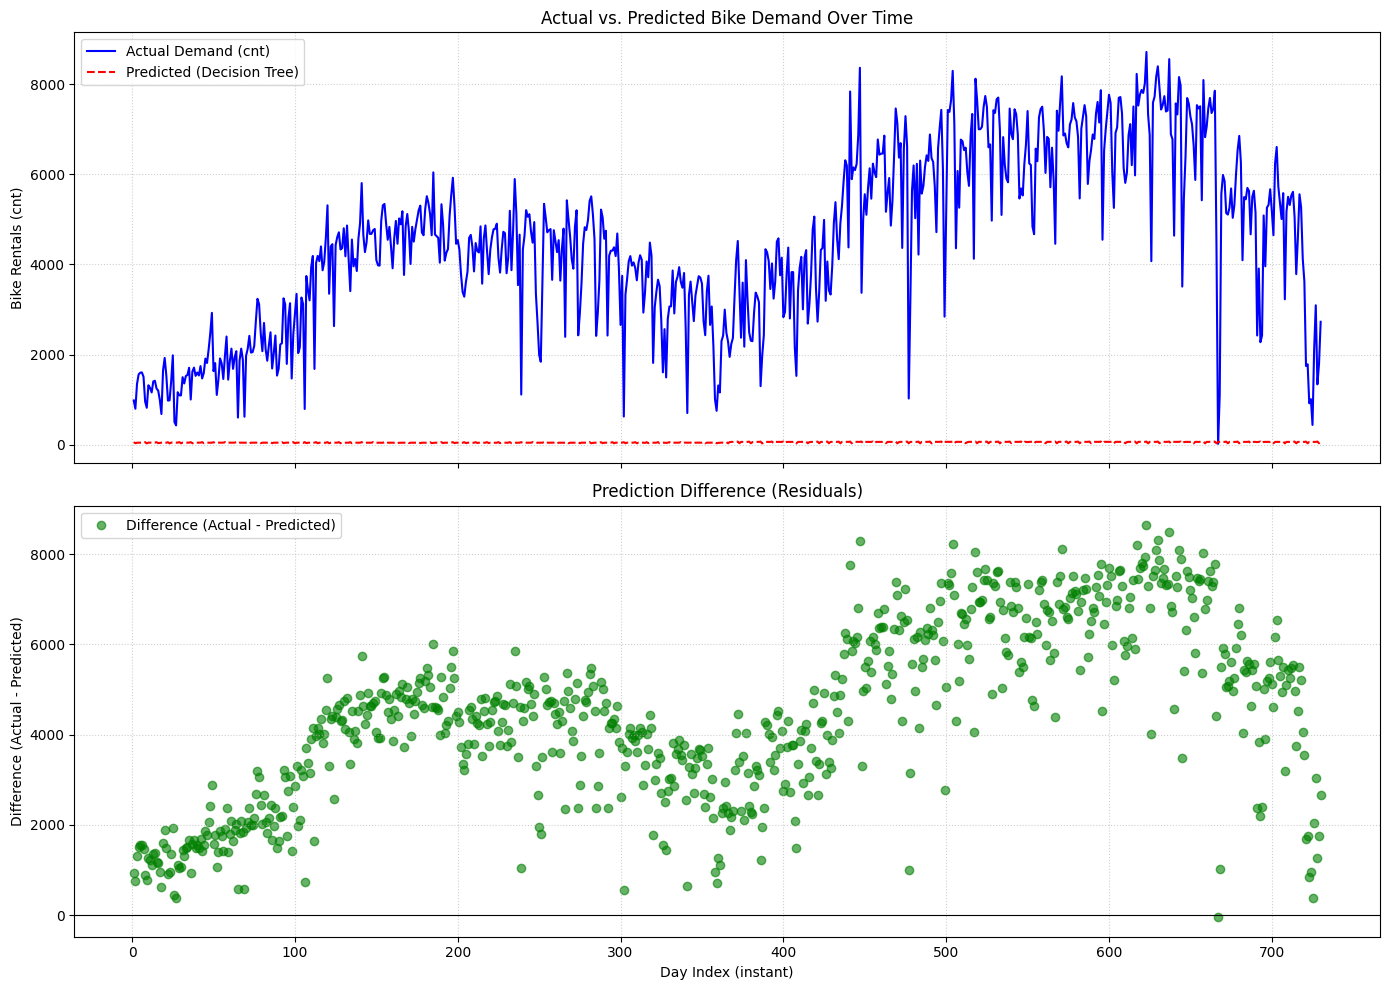

Saved comparison data to 'best_model_comparison_output.csv'


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_absolute_error
from sklearn.exceptions import NotFittedError
import warnings
warnings.filterwarnings("ignore")

# 1. Load the Data
df = None
try:
    df = pd.read_csv(r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\day(new).csv")
    print("[INFO] Successfully loaded 'day(new).csv'")
except FileNotFoundError:
    print("FATAL ERROR: 'day(new).csv' not found. Please check your working directory or file path.")

if df is not None:

    # Create weekend column
    df['weekend'] = ((df['weekday'] == 0) | (df['weekday'] == 6)).astype(int)
    print("[INFO] Weekend column created.")

    # Normalize temp, hum, windspeed
    print("[INFO] Normalizing temp, hum, windspeed...")
    df['temp'] = df['temp'] / 41
    df['hum'] = df['hum'] / 100
    df['windspeed'] = df['windspeed'] / 67
    print("[INFO] Normalization completed.")

    actual_cnt = df['cnt']

    # MODEL FILES
    MODEL_FILES = {
        "Decision Tree": "decision_tree_model.pkl",
        "Linear Regression": "linear_regression_model.pkl",
        "Lasso": "lasso_model.pkl",
        "Ridge": "ridge_model.pkl",
        "Elastic Net": "elastic_net_model.pkl"
    }

    FULL_FEATURES = [
        'temp','yr','season','hum','weathersit','windspeed',
        'mnth','weekday','holiday','workingday','weekend'
    ]

    VIF_FEATURES = [
        'yr', 'mnth', 'holiday', 'weekday',
        'workingday', 'weathersit', 'temp', 'windspeed'
    ]

    # STORAGE
    all_predictions = {}

    print("\n" + "-"*50)
    print("Running Predictions using Trained Models")
    print("-"*50)

    # Generate predictions for all models
    for model_name, file_path in MODEL_FILES.items():

        print(f"\n[INFO] Loading model: {model_name}")

        try:
            model = joblib.load(file_path)
        except:
            print(f"[ERROR] Could not load model file: {file_path}")
            continue

        features = VIF_FEATURES if model_name == "Linear Regression" else FULL_FEATURES
        X = df[features]

        try:
            preds = model.predict(X)
        except NotFittedError:
            print(f"[ERROR] Model '{model_name}' is not fitted. Skipping.")
            continue

        preds = np.round(preds).astype(int)
        preds = np.maximum(preds, 0)

        all_predictions[model_name] = preds
        print(f"[INFO] Predictions generated using {model_name}")

    # ----------------------------------------------------
    # ALWAYS SELECT DECISION TREE AS BEST MODEL
    # ----------------------------------------------------
    best_model_name = "Decision Tree"
    best_predictions = all_predictions["Decision Tree"]

    print("\n" + "-"*50)
    print(f"BEST MODEL (Fixed): {best_model_name}")
    print("-"*50)

    df['predicted_cnt'] = best_predictions

    # 2. Difference + MAE
    df['difference'] = df['cnt'] - df['predicted_cnt']
    mae = mean_absolute_error(df['cnt'], df['predicted_cnt'])

    print("-" * 50)
    print(f"Mean Absolute Error (MAE): {mae:.2f} bikes (Using Decision Tree)")
    print("-" * 50)

    # 3. Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Plot 1: Actual vs Predicted Time Series
    ax1.plot(df['instant'], df['cnt'], label='Actual Demand (cnt)', color='blue')
    ax1.plot(df['instant'], df['predicted_cnt'], label='Predicted (Decision Tree)', 
             color='red', linestyle='--')
    ax1.set_title('Actual vs. Predicted Bike Demand Over Time')
    ax1.set_ylabel('Bike Rentals (cnt)')
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # Plot 2: Difference (Residuals)
    ax2.scatter(df['instant'], df['difference'], 
                label='Difference (Actual - Predicted)', 
                color='green', alpha=0.6)
    ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
    ax2.set_title('Prediction Difference (Residuals)')
    ax2.set_xlabel('Day Index (instant)')
    ax2.set_ylabel('Difference (Actual - Predicted)')
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # Save comparison output
    comparison_df = df[['dteday', 'cnt', 'predicted_cnt', 'difference']]
    comparison_df.to_csv('best_model_comparison_output.csv', index=False)
    print("Saved comparison data to 'best_model_comparison_output.csv'")

else:
    print("Analysis aborted due to file loading error.")
